In [11]:
"!git clone https://github.com/Ludostck/Projet.git"
path = "./Images/"

In [12]:
IMAGE_SIZE = 224
CLASSES = ['Galaxie', 'Nébuleuse', 'Comète','Lune']

In [1]:
import glob
import PIL
from PIL import Image
import numpy as np
import os
import shutil
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Concatenate, Add, Activation, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint




In [14]:


def load_data(data_path, classes, dataset='train', image_size=64):
    num_images = 0
    for class_name in classes:
        dir_path = os.path.join(data_path, dataset, class_name)
        num_images += len([item for item in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, item))])
    
    x = np.zeros((num_images, image_size, image_size, 3), dtype=np.uint8)
    y = np.zeros((num_images, 1), dtype=int)
    
    current_index = 0
    
    for idx_class, class_name in enumerate(classes):
        dir_path = os.path.join(data_path, dataset, class_name)
        for item in sorted(os.listdir(dir_path)):
            file_path = os.path.join(dir_path, item)
            if os.path.isfile(file_path):
                with Image.open(file_path) as img:
                    img = img.convert('RGB').resize((image_size, image_size), Image.Resampling.LANCZOS)
                    x[current_index] = np.asarray(img, dtype=np.uint8)
                    y[current_index] = idx_class
                    current_index += 1
                
    return x, y


x_train, y_train = load_data(path, CLASSES, dataset='Train', image_size=IMAGE_SIZE)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_val, y_val = load_data(path, CLASSES, dataset='Validation', image_size=IMAGE_SIZE)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_test, y_test = load_data(path, CLASSES, dataset='Test', image_size=IMAGE_SIZE)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
# Normalisation des entrées via une division par 255 des valeurs de pixel.
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255



x_train shape: (6981, 224, 224, 3)
y_train shape: (6981, 1)
x_val shape: (1312, 224, 224, 3)
y_val shape: (1312, 1)
x_test shape: (435, 224, 224, 3)
y_test shape: (435, 1)


C:\Users\ludos\AppData\Local\Temp\ipykernel_30944\46290205.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(CLASSES[int(y_train[image_index])])


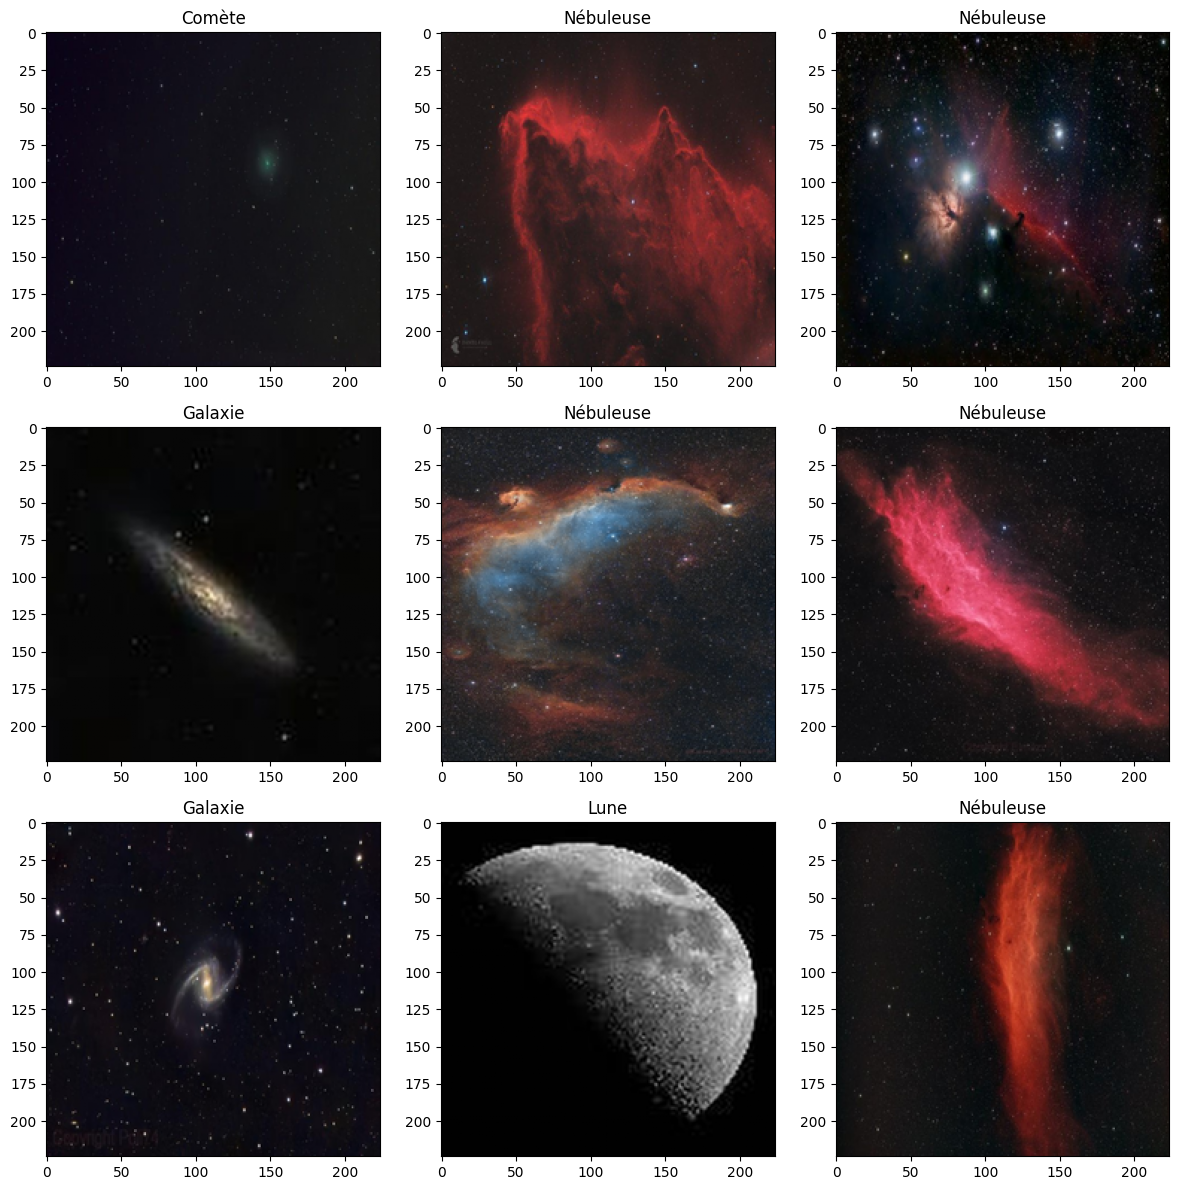

In [15]:
import matplotlib.pyplot as plt
import numpy as np

num_images = 9  # Choix aléatoire entre 1 et 9 images

plt.figure(figsize=(12, 12))

# Générer des indices aléatoires basés sur la taille de x_train
shuffle_indices = np.random.permutation(len(x_train))

for i in range(num_images):
    plt.subplot(3, 3, i+1)  # S'assurer de ne pas dépasser 9
    # Utiliser un index aléatoire pour sélectionner l'image
    image_index = shuffle_indices[i]
    image = x_train[image_index]
    # Afficher le titre basé sur l'étiquette de l'image choisie
    plt.title(CLASSES[int(y_train[image_index])])
    # Normaliser l'image pour l'affichage
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import optimizers

model = Sequential()

# Première couche de convolution et pooling
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(BatchNormalization())  # Ajout de la normalisation par batch
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Ajout d'un dropout pour réduire le sur-ajustement

# Deuxième couche de convolution et pooling
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Troisième couche de convolution et pooling
model.add(Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Quatrième couche de convolution et pooling
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Augmentation du taux de dropout pour les couches plus profondes

# Vectorisation des features et couches denses
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Haut taux de dropout avant la couche finale pour minimiser le sur-ajustement
model.add(Dense(5, activation='softmax'))  # 5 classes

c:\Users\ludos\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,036,965 (49.73 MB)

 Trainable params: 13,035,301 (49.73 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [18]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

In [19]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32)  # Augmentation du nombre d'époques et ajustement de la taille des batchsà


Epoch 1/20
 19/219 ━━━━━━━━━━━━━━━━━━━━ 5:20 2s/step - accuracy: 0.5779 - loss: 1.5951

KeyboardInterrupt: 

In [11]:
model.save("Projet_2.keras")


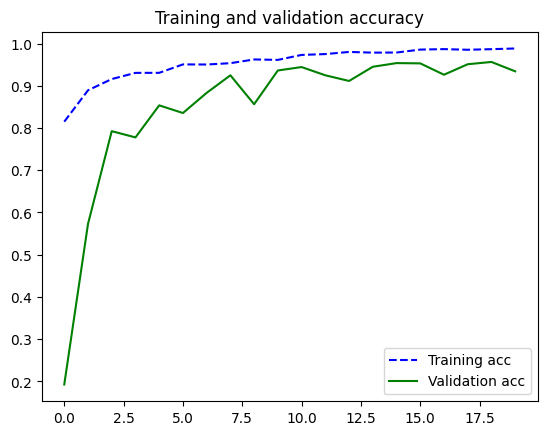

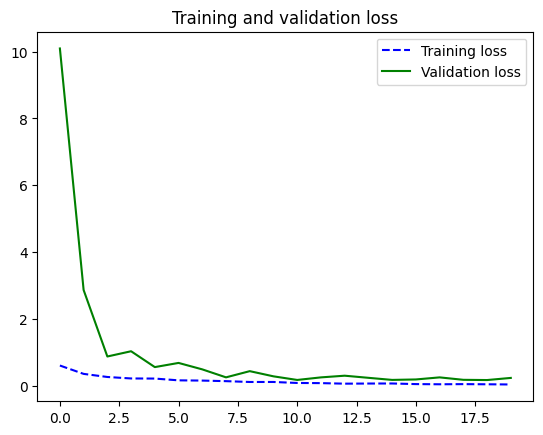

In [12]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
plot_training_analysis()

In [13]:
# Effectuer une prédiction avec le modèle sur x_test
predictions_t = model.predict(x_test)

# Convertir les prédictions en étiquettes réelles
# Utilisez np.argmax pour convertir les prédictions de one-hot encoding vers des étiquettes
predictions_t_labels = np.argmax(predictions_t, axis=1)  # Correction ici : utiliser axis=1

# Calculer la précision sur le jeu de test
# Assurez-vous que y_test est de la bonne forme; il devrait être un vecteur simple de labels.
accuracy_t = np.mean(predictions_t_labels == y_test.flatten()) * 100
print(f'Précision sur le jeu de test : {accuracy_t:.2f}%') 

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step
Précision sur le jeu de test : 94.11%


In [14]:
from sklearn.metrics import classification_report
predictions_val = model.predict(x_val)

predictions_val_labels = np.argmax(predictions_val, axis=1)  # Correction ici : utiliser axis=1

# Générez le rapport de classification
report_val = classification_report(y_val, predictions_val_labels, target_names=CLASSES, output_dict=False)
report_t = classification_report(y_test, predictions_t_labels, target_names=CLASSES, output_dict=False)

print(report_val)
print()
print(report_t)

47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step
              precision    recall  f1-score   support

     Galaxie       0.99      0.87      0.93       391
   Nébuleuse       0.94      0.97      0.96       470
      Comète       0.82      0.98      0.89       254
         Ama       0.96      0.84      0.90       177
        Lune       0.99      0.98      0.98       197

    accuracy                           0.93      1489
   macro avg       0.94      0.93      0.93      1489
weighted avg       0.94      0.93      0.93      1489


              precision    recall  f1-score   support

     Galaxie       0.99      0.88      0.93       130
   Nébuleuse       0.94      0.96      0.95       156
      Comète       0.81      0.99      0.89        84
         Ama       1.00      0.89      0.94        57
        Lune       1.00      0.98      0.99        65

    accuracy                           0.94       492
   macro avg       0.95      0.94      0.94       492
weighted avg       0.95      0.94 

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step


C:\Users\ludos\AppData\Local\Temp\ipykernel_30944\1817701839.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = CLASSES[int(y_test[image_index])]


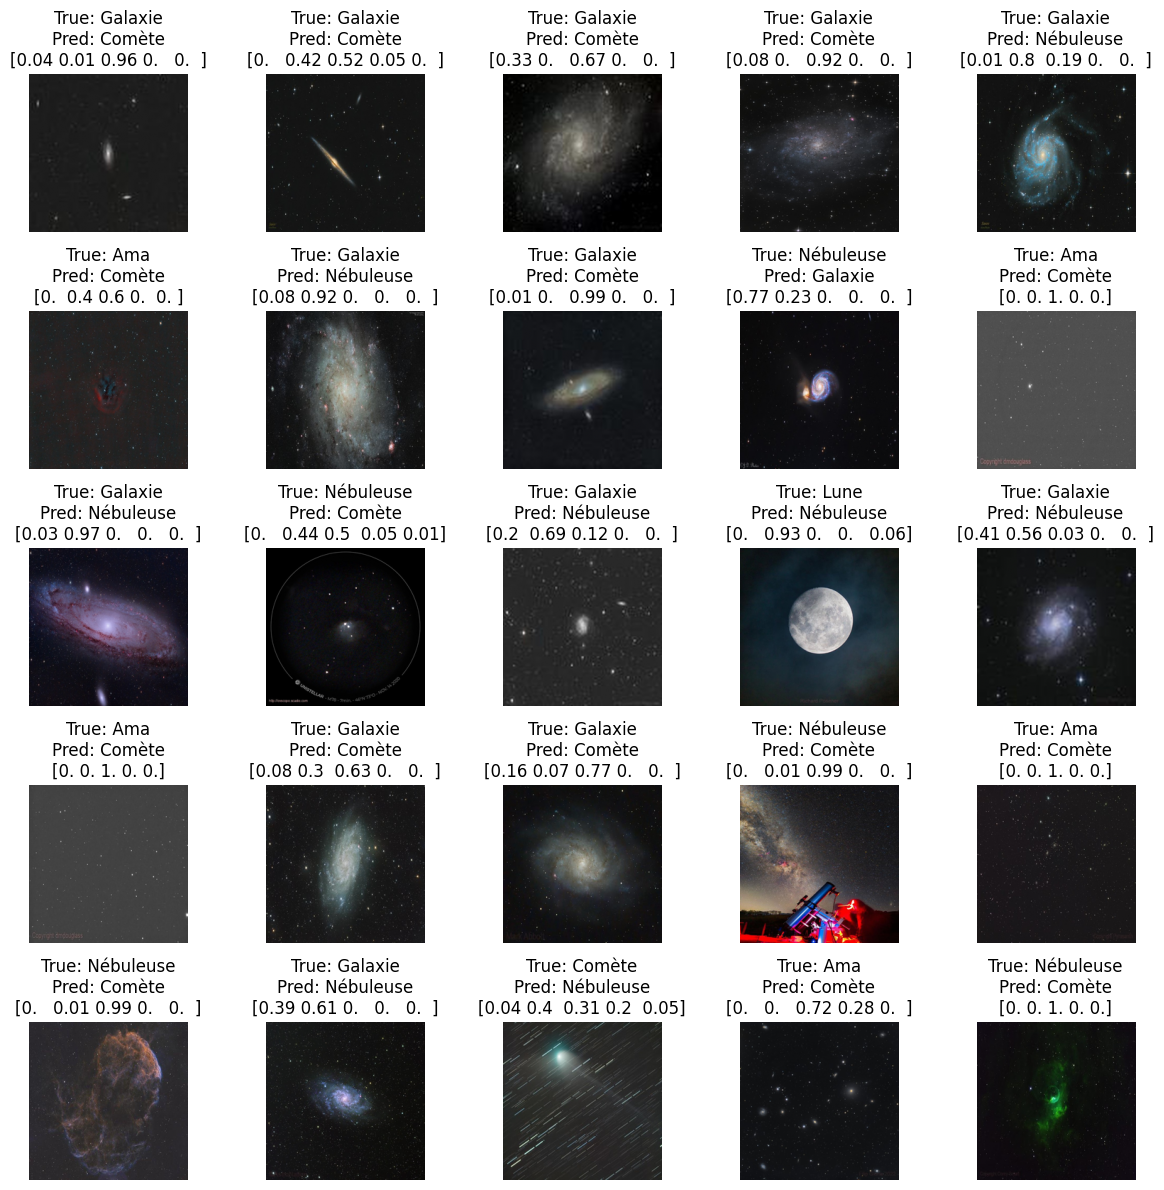

In [10]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

model = load_model('Projet_2.keras')

# Nous utiliserons toutes les images de test
num_images = len(x_test)
shuffle_indices = np.random.permutation(num_images)

predictions = model.predict(x_test[shuffle_indices])

# Initialisation de la liste pour garder les indices des mauvaises prédictions
wrong_indices = []

plt.figure(figsize=(12, 12))

# On parcourt toutes les images dans l'ordre aléatoire
for i in range(num_images):
    image_index = shuffle_indices[i]
    image = x_test[image_index]
    
    true_label = CLASSES[int(y_test[image_index])]
    
    # Obtenir la classe prédite et les probabilités
    predicted_label = CLASSES[np.argmax(predictions[i])]
    
    # Vérifier si la prédiction est incorrecte
    if predicted_label != true_label:
        wrong_indices.append((i, image, true_label, predicted_label, predictions[i]))
        
        # Si nous avons collecté 25 mauvaises prédictions, on arrête de chercher
        if len(wrong_indices) == 25:
            break

# Afficher les 25 premières mauvaises prédictions
for i, (idx, image, true_label, predicted_label, probs) in enumerate(wrong_indices):
    plt.subplot(5, 5, i+1)
    plt.title(f"True: {true_label}\nPred: {predicted_label}\n{np.round(probs, 2)}")
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [2]:
import glob
import PIL
import numpy as np
import os
import shutil
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, concatenate, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np

In [3]:


modele_charge = load_model('meilleur_modele_2.h5')

IMAGE_SIZE = 225
CLASSES = ['Galaxie', 'Nébuleuse', 'Comète','Lune',"Saturne"]
def load_image():
    # Choix de l'image
    file_path = filedialog.askopenfilename()
    if not file_path:  # Vérifie si le chemin n'est pas vide
        return
    
    # Chargement et affichage de l'image choisie
    img = Image.open(file_path)
    img = img.resize((600, 600), Image.Resampling.LANCZOS)  # Redimensionnement de l'image
    img_tk = ImageTk.PhotoImage(img)
    panel.configure(image=img_tk)
    panel.image = img_tk  # Garde une référence
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.Resampling.LANCZOS)
    classify_image(img)  # Classifie l'image

def classify_image(img):
    # Prétraitement de l'image pour la classification
    img_array = np.array(img) / 255.0  # Normalisation
    img_array = img_array.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))  # Ajout de la dimension du batch

    # Prédiction
    predictions = modele_charge.predict(img_array)
    predicted_class = CLASSES[np.argmax(predictions)]  # Remplacer CLASSES par vos classes réelles
    prob = np.max(predictions)
    
    # Affichage de la classe prédite et de la probabilité
    result_label.config(text=f'Predicted: {predicted_class} ({prob:.2f})')

# Création de la fenêtre Tkinter
root = tk.Tk()
root.title('Image Classifier')

# Ajout d'un bouton pour charger une image
btn_load = tk.Button(root, text='Load Image', command=load_image)
btn_load.pack()

# Panneau pour afficher l'image choisie
panel = tk.Label(root)
panel.pack()

# Étiquette pour afficher la prédiction
result_label = tk.Label(root, text='Prediction will appear here', font=('Arial', 16))
result_label.pack()

# Lancement de l'application
root.mainloop()




1/1 [==============================] - 0s 33ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\ludos\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\ludos\AppData\Local\Temp\ipykernel_33252\541243634.py", line 18, in load_image
    classify_image(img)  # Classifie l'image
    ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ludos\AppData\Local\Temp\ipykernel_33252\541243634.py", line 23, in classify_image
    img_array = img_array.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))  # Ajout de la dimension du batch
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: cannot reshape array of size 50625 into shape (1,225,225,3)


1/1 [==============================] - 0s 37ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\ludos\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\ludos\AppData\Local\Temp\ipykernel_33252\541243634.py", line 18, in load_image
    classify_image(img)  # Classifie l'image
    ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ludos\AppData\Local\Temp\ipykernel_33252\541243634.py", line 23, in classify_image
    img_array = img_array.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))  # Ajout de la dimension du batch
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: cannot reshape array of size 50625 into shape (1,225,225,3)


1/1 [==============================] - 0s 44ms/step


In [3]:
import os
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from PIL import UnidentifiedImageError


# Dossier contenant les images à classifier
image_folder = 'Lunes_2'

# Dossier pour sauvegarder les images classifiées comme Nébuleuse
save_folder = 'Lu_att'


if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Parcourir toutes les images dans le dossier
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    
    try:
        # Charger l'image, ajuster les dimensions et prétraiter
        img = Image.open(image_path)
        img_array = np.array(img) / 255.0  # Normalisation
        img_array = img_array.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))  # Ajout de la dimension du batch
        
        # Prédire la classe de l'image
        predictions = model.predict(img_array)
        predicted_class = CLASSES[np.argmax(predictions)]  # Remplacer CLASSES par vos classes réelles
        prob = np.max(predictions)
        
        # Vérifier si l'image est classifiée comme Nébuleuse avec proba >= 0.95
        if predicted_class == "Lunes"  and prob >= 0.98 :
            # Sauvegarder l'image dans le nouveau dossier
            print(predicted_class)
            print(prob)
            save_path = os.path.join(save_folder, image_name)
            image.save(save_path)
        else:
            # Supprimer l'image si elle ne correspond pas à la classification désirée
            os.remove(image_path)

    except UnidentifiedImageError:
        print(f"Erreur : Impossible d'identifier ou de lire l'image {image_name}. Elle sera supprimée.")
        os.remove(image_path)
    except Exception as e:
        print(f"Erreur inattendue avec l'image {image_name}: {e}")

print("Classification et nettoyage terminés.")


Erreur inattendue avec l'image 059xks.jpg: cannot reshape array of size 1080000 into shape (1,128,128,3)
Erreur inattendue avec l'image 05pjbw.jpg: cannot reshape array of size 1153200 into shape (1,128,128,3)
Erreur inattendue avec l'image 0azdnc.jpg: cannot reshape array of size 758880 into shape (1,128,128,3)
Erreur inattendue avec l'image 0b7m9o.jpg: cannot reshape array of size 645420 into shape (1,128,128,3)
Erreur inattendue avec l'image 0dhk07.jpg: cannot reshape array of size 1080000 into shape (1,128,128,3)
Erreur inattendue avec l'image 0gv5ws.jpg: cannot reshape array of size 1080000 into shape (1,128,128,3)
Erreur inattendue avec l'image 0hwzwx.jpg: cannot reshape array of size 1080000 into shape (1,128,128,3)
Erreur inattendue avec l'image 0i54fo.jpg: cannot reshape array of size 1080000 into shape (1,128,128,3)
Erreur inattendue avec l'image 0n71c8.jpg: cannot reshape array of size 1080000 into shape (1,128,128,3)
Erreur inattendue avec l'image 0nurvx.jpg: cannot reshape

KeyboardInterrupt: 